# Housekeeping

In [1]:
#!pip install kagglehub

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import pathlib
import kagglehub
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Input, Rescaling, Conv3D, MaxPooling3D, Activation, BatchNormalization, Dropout, Flatten, Dense, RandomFlip, RandomRotation)
from tensorflow.keras.layers import GRU, Conv2D, TimeDistributed, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import os
import datetime
import os

In [4]:
np.random.seed(44)
import random as rn
rn.seed(44)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(44)

# Get Data

Check GPU Status with NVIDIA-SMI  

In [5]:
!nvidia-smi

Mon Mar  3 02:10:52 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 5000                Off | 00000000:41:00.0 Off |                  Off |
| 33%   30C    P8              11W / 230W |      6MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

The data has been uploaded to Kaggle.

https://www.kaggle.com/datasets/kk20krishna/gesture-recognition-dataset


Each video is a sequence of 30 frames (or images).
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.


The data consists of a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images).
Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 


Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

## Download Dataset from KaggleHub

In [6]:
path = kagglehub.dataset_download("kk20krishna/gesture-recognition-dataset")

100%|██████████| 1.60G/1.60G [01:34<00:00, 18.2MB/s]

Extracting model files...


Define Project Data Path

In [7]:
project_data_path = pathlib.Path(path) / 'Project_data'

print("Path to project data:", project_data_path)

Path to project data: /home/.cache/kagglehub/datasets/kk20krishna/gesture-recognition-dataset/versions/1/Project_data


## Explore Dataset Structure

In [8]:
print('Files in project_data_path:')
for folder in project_data_path.iterdir():
    if folder.is_file():
        print(folder.name)

print('\nFolders in project_data_path:')
for folder in project_data_path.iterdir():
    if folder.is_dir():
        print(folder.name,
              ':',
              len(list(subfolder for subfolder in folder.iterdir())), 'folders',
              'and',
              len(list(folder.glob('*/*'))), 'files')


Files in project_data_path:
train.csv
val.csv

Folders in project_data_path:
train : 663 folders and 19890 files
val : 100 folders and 3000 files


## Explore Doc files


Define Paths for Training and Validation Data  

In [9]:
train_doc_path = project_data_path/'train.csv'
val_doc_path = project_data_path/'val.csv'
train_data_path = project_data_path/'train'
val_data_path = project_data_path/'val'

Read and Parse Dataset Metadata  

In [10]:
def read_doc_file(file):
    """
    Reads a .doc file and returns its content as a list of lists, where each line is split by a semicolon.

    Parameters:
    file (str): Path to the .doc file.

    Returns:
    list: A list of lists containing parsed lines from the file.
    """
    train_list = []
    with open(file, 'r') as file:
        # Skip header if exists
        # next(file, None)
        for line in file:
            train_list.append(line.strip().split(';'))
    return train_list

train_folders_data = read_doc_file(train_doc_path)
print(len(train_folders_data))

val_folders_data = read_doc_file(val_doc_path)
print(len(val_folders_data))

663
100


The dataset has 663 train and 100 validation videos.

## Analyze class distribution

This analysis helps in understanding class imbalance, which may impact model performance and require techniques like data augmentation or class-weight adjustments. 

In [29]:
# Analyze class distribution

gestures = [folder[2] for folder in train_folders_data]
gesture, counts = np.unique(gestures, return_counts=True)

for i in range(len(gesture)):
    print(counts[i], gesture[i])

print("\n")

gestures = [folder[2] for folder in val_folders_data]
gesture, counts = np.unique(gestures, return_counts=True)

for i in range(len(gesture)):
    print(counts[i], gesture[i])

136 0
137 1
130 2
137 3
123 4


18 0
23 1
22 2
21 3
16 4


**We can see that the class distribution is sufficiently balanced.**


**Train Data:**

136 samples - Gesture 0

137 samples - Gesture 1

130 samples - Gesture 2

137 samples - Gesture 3

123 samples - Gesture 4


**Val Data"**

18 samples - Gesture 0

23 samples - Gesture 1

22 samples - Gesture 2

21 samples - Gesture 3

16 samples - Gesture 4

## Analyze Videos in Folder

Create function to print videos

**Note:** It is important to sort frames in the video folder since the order of the images is important for gesture recognition.

In [106]:
def print_videos_in_folder(folder_paths, frame_rate=None, frame_size=None):
    """
    Displays images from a given folder in a grid layout using Matplotlib.

    Parameters:
    folder_paths (Path): Path to the folder containing images.
    frame_rate (int, optional): If provided, selects images at intervals based on the given frame rate.
    frame_size (tuple, optional): If provided, resizes images to the specified (width, height).

    The function arranges the images in a grid of 3 rows and 10 columns, ensuring the order of images is preserved.
    """

    # Get image paths
    image_paths = sorted(list(folder_paths.iterdir())) # It is important to sort since the order of the images is important for gesture recognition

    # Frame rate
    if frame_rate is not None:
        frame_slice = len(image_paths) // frame_rate  # Step size for slicing
        image_paths = image_paths[::frame_slice]

    # Define grid size
    rows, cols = 3, 10
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Adjust figure size

    # Frame rate
    #frame_slice = len(video_data) // frame_rate  # Step size for slicing

    # Loop through images and plot them
    for idx, image_path in enumerate(image_paths):
        img = cv2.imread(str(image_path))  # Read image using OpenCV
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            # Resize
            if frame_size is not None: img_rgb = cv2.resize(img_rgb, frame_size)
            row, col = divmod(idx, cols)  # Calculate row and column indices
            axes[row, col].imshow(img_rgb)
            axes[row, col].axis("off")  # Hide axis labels
        else:
            print(f"Could not read image: {image_path}")

    # Hide unused subplots
    total_images = len(image_paths)
    total_slots = rows * cols  # Total number of subplots in the grid

    if total_images < total_slots:
        for idx in range(total_images, total_slots):
            row, col = divmod(idx, cols)
            fig.delaxes(axes[row, col])  # Remove unused axes

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

Select first training folder

In [31]:
# Select one training folder
prt_folder_name = [folder[0] for folder in train_folders_data][0] # select only one folder
prt_folder_path = train_data_path / prt_folder_name

Let us first take a look at all frames in default size the frame rate.

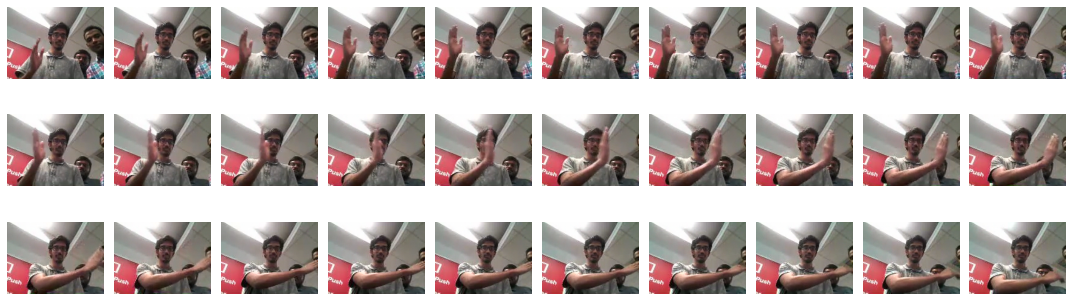

In [32]:
# Pring Images in Folder as-is
print_videos_in_folder(prt_folder_path)

Now let us look at the video frames at hald the frame rate

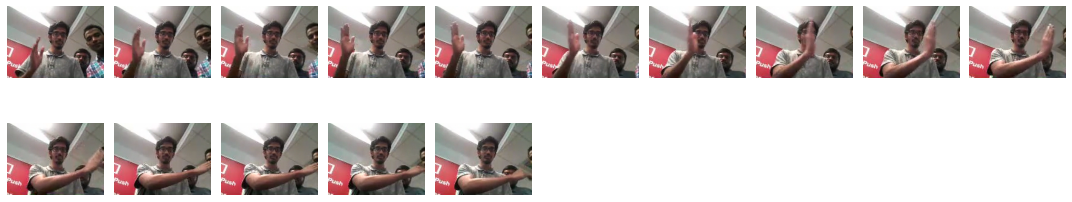

In [33]:
# Print Images in Folder with frame rate 15
print_videos_in_folder(prt_folder_path, frame_rate=15)

Now let us look at the video at a frame rate of 10.

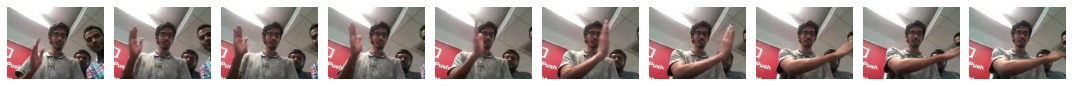

In [34]:
# Print Images in Folder with frame rate 10
print_videos_in_folder(prt_folder_path, frame_rate=10)

Now let us look at the video at a frame rate of 5.

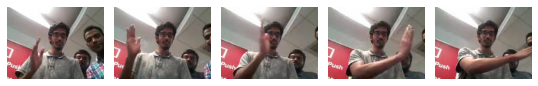

In [35]:
# Print Images in Folder with frame rate 5
print_videos_in_folder(prt_folder_path, frame_rate=5)

**Observations:**
    1. The order of the frames is importatn to identify gesture.
    2. THe lower the frame rate gets the harder it becomes to identify the gesture.

Now let us resize the frames to 80x80

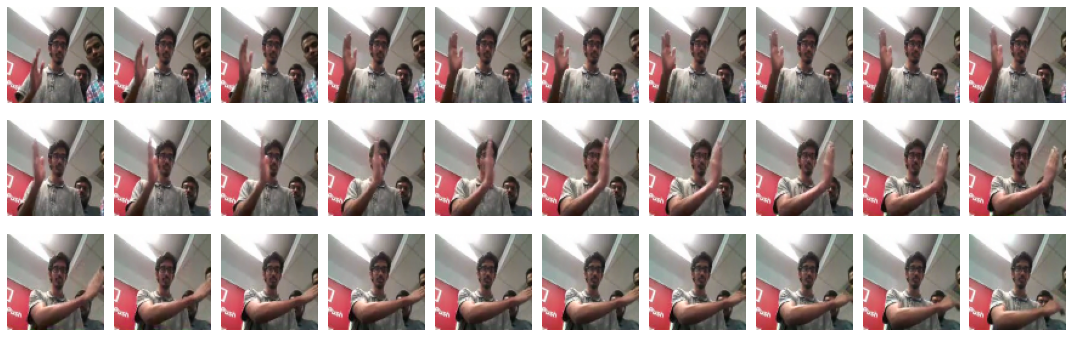

In [107]:
# Print Images in Folder after resize to 80x80
print_videos_in_folder(prt_folder_path, frame_size=(80,80))

Now to 32x32

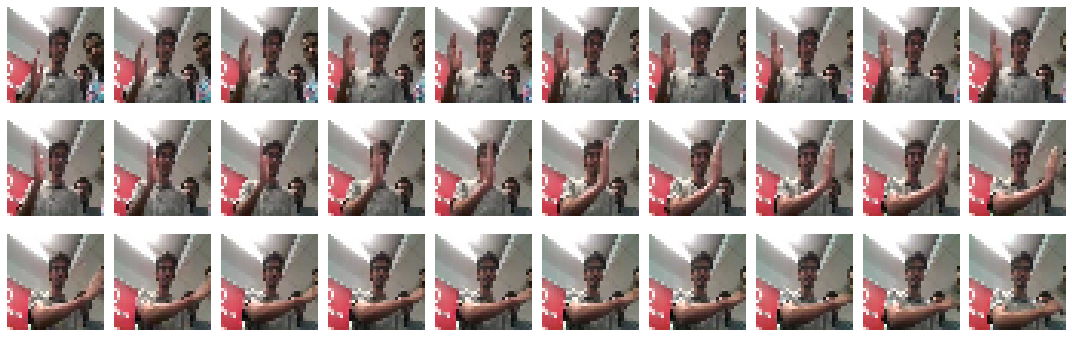

In [37]:
# Print Images in Folder after resize to 32x32
print_videos_in_folder(prt_folder_path, frame_size=(32,32))

**Observation:**

    1. Framesize of 32x32 results in pixalization

Now let us try a combination of reduced frame rate and smaller size frames

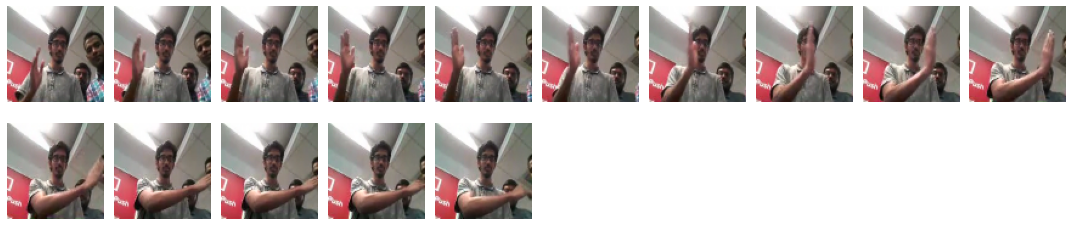

In [38]:
# Print Images with reduced frame rate and size
print_videos_in_folder(prt_folder_path, frame_rate=15, frame_size=(80,80))

# Generator
This function, `generator`, is a Python generator that yields batches of processed video frames along with their labels.
It is used for efficiently loading and preprocessing video data during model training.

In [11]:
def generator(source_path, folder_list, batch_size, frame_rate, frame_size, verbose=-1):
    """
    Generator function to yield batches of video frames.

   a Parameters:
    source_path (Path): Base directory containing video folders.
    folder_list (list): List of folder names containing videos.
    batch_size (int): Number of videos per batch.
    frame_rate (int, optional): Frame rate for video. 10, 20, 30, etc.
    frame_size (tuple, optional): Target size of frames (width, height).
    verbose (int, optional): Verbosity level (0=none, 1=basic, 2=detailed, 3=debug). Default is 0.

    Yields:
    np.ndarray: Batch of processed video frames.
    """

    # Determine the number of batches
    num_batches = (len(folder_list) + batch_size - 1) // batch_size

    if verbose>=0: # Logging level 0
      print('\n---Starting Generator---', '\n',
            'Source Path = ', source_path, '\n',
            '# of videos', len(folder_list), ' | ',
            'batch size =', batch_size, ' | ',
            '# of batches', num_batches, ' | ',
            'frame rate =', frame_rate, ' | ',
            'frame size =', frame_size, ' | ',
            'verbose =', verbose, ' | ',
            '\n------------------------', '\n',
            )

    while True:
        # Shuffle folder list to randomize batch processing
        folder_list_rand = np.random.permutation(folder_list)

        if verbose>=1: print("Generating new set of number of batches:", num_batches) # Logging level 1

        # Iterate over batches
        for batch in range(num_batches):

            # Determine the actual batch size for this iteration
            remaining_batch_size = len(folder_list_rand) - (batch * batch_size)
            create_batch_size = min(remaining_batch_size, batch_size)

            if verbose>=1: print("  Processing Batch#", batch, " remaining_batch_size: ", remaining_batch_size, " create_batch_size: ", create_batch_size) # Logging level 1

            # Process each video in the batch
            batch_data = []
            batch_labels = []
            for video in range(create_batch_size): # iterate over the batch_size
                video_idx = video + (batch*batch_size)
                video_path = source_path/folder_list_rand[video_idx][0]
                if verbose>=2: print("    Processing folder#", video_idx, " : ",
                                     len([file for file in video_path.iterdir()]), " files",
                                     " : ", folder_list_rand[video_idx][0]) # Logging level 2

                # Process frames in the video
                video_data = []
                for frame_idx, frame_path in enumerate(sorted([file for file in video_path.iterdir()])):
                    if verbose>=3: print("      Processing Frame: ", frame_path) # Logging level 3

                    frame = cv2.imread(str(frame_path))  # OpenCV reads images as (height, width, channels)
                    if frame is None:
                      print("Error!!! reading image at path: ", frame_path)
                      break

                    # Resize and store the frame
                    frame = cv2.resize(frame, frame_size) # but cv2.resize(frame, frame_size) expects (width, height)

                    # Collect frames for video
                    video_data.append(frame)

                # Frame rate
                frame_slice = len(video_data) // frame_rate  # Step size for slicing
                video_data = video_data[::frame_slice]

                #Collect videos for batch
                batch_data.append(video_data)
                batch_labels.append(int(folder_list_rand[video_idx][2]))

            # one-hot encode the labels
            #num_classes = len(set(label[2] for label in folder_list))  # Calculate unique class labels
            num_classes = 5
            batch_labels = to_categorical(batch_labels, num_classes=num_classes)

            # Yield the batch as a NumPy array
            yield np.array(batch_data, dtype=np.float32), np.array(batch_labels)


Let us now test the generator fucntion by generating few batches. "verbose" will be used to debug as needed.

In [12]:
# Test generator

temp_batch_size = 32

# Initialize the generator
temp_data_generator = generator(train_data_path, train_folders_data[:200], batch_size=temp_batch_size, frame_rate=10, frame_size=(64, 64), verbose=1)

num_temp_sequences = len(train_folders_data[:200])
temp_batches_per_epoch = (num_temp_sequences + temp_batch_size - 1) // temp_batch_size
print("num_temp_sequences: ", num_temp_sequences)
print("temp_batches_per_epoch: ", temp_batches_per_epoch)

# Loop through epochs and steps
for epoch in range(2):
  print("Epoch#", epoch,)
  for step in range(temp_batches_per_epoch):
    batch_data, batch_labels = next(temp_data_generator)  # Get data and labels for current step
    print(" Step#", step, " --> ", batch_data.shape, batch_labels.shape)

num_temp_sequences:  200
temp_batches_per_epoch:  7
Epoch# 0

---Starting Generator--- 
 Source Path =  /home/.cache/kagglehub/datasets/kk20krishna/gesture-recognition-dataset/versions/1/Project_data/train 
 # of videos 200  |  batch size = 32  |  # of batches 7  |  frame rate = 10  |  frame size = (64, 64)  |  verbose = 1  |  
------------------------ 

Generating new set of number of batches: 7
  Processing Batch# 0  remaining_batch_size:  200  create_batch_size:  32
 Step# 0  -->  (32, 10, 64, 64, 3) (32, 5)
  Processing Batch# 1  remaining_batch_size:  168  create_batch_size:  32
 Step# 1  -->  (32, 10, 64, 64, 3) (32, 5)
  Processing Batch# 2  remaining_batch_size:  136  create_batch_size:  32
 Step# 2  -->  (32, 10, 64, 64, 3) (32, 5)
  Processing Batch# 3  remaining_batch_size:  104  create_batch_size:  32
 Step# 3  -->  (32, 10, 64, 64, 3) (32, 5)
  Processing Batch# 4  remaining_batch_size:  72  create_batch_size:  32
 Step# 4  -->  (32, 10, 64, 64, 3) (32, 5)
  Processing Bat

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

# Define History Function

In [13]:
def plot_history(history):
    """
    Plots the training and validation loss, as well as the training and validation categorical accuracy
    over the epochs.

    Args:
    - history (tf.keras.callbacks.History): The History object returned by model.fit(), containing
      training metrics.

    Returns:
    - None: Displays the loss and accuracy curves for both training and validation sets.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    epochs = range(1, len(history.history['loss']) + 1)  # Get number of epochs

    axes[0].plot(epochs, history.history['loss'], marker='o')
    axes[0].plot(epochs, history.history['val_loss'], marker='o')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend(['Loss', 'Validation Loss'])

    axes[1].plot(epochs, history.history['categorical_accuracy'], marker='o')
    axes[1].plot(epochs, history.history['val_categorical_accuracy'], marker='o')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training & Validation Accuracy')
    axes[1].legend(['Categorical Accuracy', 'Validation Categorical Accuracy'])

    plt.show()

# Comparison of Architecture options for Hand Gesture Recognition

| Model | Strengths | Weaknesses |
|--------|-----------|------------|
| CNN-3D | Captures both spatial and temporal features simultaneously. Works well with short video clips. No need for explicit sequential modeling. | Computationally expensive due to 3D convolutions. Requires large datasets for effective training. |
| CNN-2D + GRU | Lighter than CNN-3D. Extracts spatial features per frame and models temporal dependencies using GRU. Suitable for real-time applications. | Does not directly capture spatio-temporal dependencies like CNN-3D. Requires careful frame selection for consistency. |
| MobileNet + GRU (non-trainable base) | Lightweight and efficient for edge devices. MobileNet extracts spatial features while GRU models temporal dependencies. Faster training due to frozen base. | Loss of fine-tuned feature extraction. May not generalize well to new datasets. |
| MobileNet + GRU (trainable base) | More accurate than the non-trainable version. Fine-tuning allows better adaptation to the dataset. Still relatively lightweight. | Slightly heavier than the non-trainable version. Needs careful tuning to avoid overfitting. |
| EfficientNetB0 + GRU (trainable base) | More accurate than MobileNet while remaining efficient. Neural Architecture Search (NAS) optimizes feature extraction. GRU models temporal dependencies well. | Heavier than MobileNet but still efficient. Fine-tuning required for optimal results. |


We will experiment with these models:

- CNN-3D  
- CNN-2D + GRU  
- MobileNet + GRU (non-trainable base)  
- MobileNet + GRU (trainable base)  
- EfficientNetB0 + GRU (trainable base)  

This will help compare their performance and efficiency.

# CNN-3D Models

**Building a 3D CNN Model for Video Gesture Recognition**

**Overview**  
A 3D Convolutional Neural Network (3D CNN) is an extension of traditional CNNs designed to handle spatiotemporal data, such as videos. Unlike 2D CNNs, which extract spatial features from images, 3D CNNs apply convolutions across both spatial and temporal dimensions, capturing motion and object interactions over time.  

**How 3D CNN Works for Gesture Recognition**  
1. Input Representation: Each video is treated as a sequence of frames, forming a 4D tensor `(batch, depth, height, width, channels)`.  
2. 3D Convolutional Layers: Instead of a 2D kernel, 3D kernels** slide across frames, learning spatial and temporal dependencies.  
3. Pooling Layers: Reduces dimensions while preserving key motion features.  
4. Fully Connected Layers: Extracted features are passed to a dense network for classification.  
5. Softmax Output: Predicts the gesture class from the given video sequence.  

**Pros of 3D CNNs for Gesture Recognition:**  
 Captures motion and spatial features together – Unlike 2D CNNs, 3D CNNs understand both what and how a gesture is performed.  
 Better feature extraction – Can learn temporal dynamics directly from raw video frames.  
 End-to-end learning – No need for handcrafted feature extraction; learns directly from data.  

**Cons of 3D CNNs:**  
 Computationally expensive – Requires higher memory and processing power, making it slower than 2D CNNs.  
 Needs large datasets – Training a 3D CNN requires a significant amount of labeled video data.  
 Risk of overfitting – With more parameters, it may struggle with small datasets.  

We will build a 3D CNN model tailored for video gesture recognition, optimize it using techniques like data augmentation and regularization, and evaluate it using real-world hand gesture datasets.  

## Define conv_3D_model function

In [42]:
def conv_3D_model(frame_rate, frame_size, conv_blocks, conv_filter, full_connected):
    """
    Builds a 3D Convolutional Neural Network (CNN) model for video-based gesture detection.

    Parameters:
    -----------
    frame_rate : int
        The number of frames per video sample.
    frame_size : tuple of int
        The dimensions (height, width) of each video frame.
    conv_blocks : list of int
        A list specifying the number of filters for each convolutional block.
    conv_filter : tuple of int
        The size of the 3D convolutional kernel (depth, height, width).
    full_connected : list of int
        A list specifying the number of neurons in each fully connected layer.

    Returns:
    --------
    model : tf.keras.Model
        A compiled Keras model for gesture detection.

    Notes:
    ------
    - The input shape is (frame_rate, frame_size[0], frame_size[1], 3).
    - Pixel values are rescaled to [0,1] using a Rescaling layer.
    - The model consists of multiple 3D convolutional and max-pooling layers.
    - Dropout layers are included to prevent overfitting.
    - The final output layer uses a softmax activation function with 5 classes.
    """

    inputs = Input(shape=(frame_rate, frame_size[0], frame_size[1], 3))

    # Rescale pixel values to range [0,1] by dividing by 255
    x = Rescaling(scale=1./255, name="rescale")(inputs)

    # Create Convolution Blocks
    for filters in conv_blocks:
      x = Conv3D(filters, conv_filter, padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      x = MaxPooling3D()(x)
      x = Dropout(0.2)(x)

    # Flatten the feature map into a 1D vector
    x = Flatten()(x)

    # Fully Connected Layer:
    for units in full_connected:
        x = Dense(units)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)

    # Output Layer:
    x = Dense(5, activation="softmax")(x)

    # Define the Model
    model = tf.keras.Model(inputs, x, name="Gesture_Detection_CNN_Conv_3D")

    return model  # Return the created model

## Define train_conv_3D_model function

In [43]:
def train_conv_3D_model(name, batch_size, num_epochs, frame_rate, frame_size, conv_blocks, conv_filter, full_connected):
    """
    Builds a 3D Convolutional Neural Network (CNN) model for video-based gesture recognition.

    Parameters:
    -----------
    frame_rate : int
        Number of frames in each video sample.
    frame_size : tuple (height, width)
        Dimensions of each video frame.
    conv_blocks : list of int
        List specifying the number of filters in each convolutional block.
    conv_filter : tuple (depth, height, width)
        Size of the 3D convolutional kernel.
    full_connected : list of int
      List specifying the number of neurons in each fully connected layer.

    Returns:
    --------
    model : tf.keras.Model
        A compiled Keras model for gesture recognition.

    Model Architecture:
    -------------------
    - Input shape: (frame_rate, frame_size[0], frame_size[1], 3).
    - Rescaling layer to normalize pixel values.
    - Multiple 3D convolutional layers followed by MaxPooling layers.
    - Dropout layers (50% rate) to prevent overfitting.
    - Fully connected dense layers with ReLU activation.
    - Output layer with softmax activation (5 classes).
    """

    # Generate data
    train_generator  = generator(train_data_path, train_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    val_generator = generator(val_data_path, val_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    # Create the model instance
    model = conv_3D_model(frame_rate=frame_rate, frame_size=frame_size, conv_blocks=conv_blocks, conv_filter=conv_filter, full_connected=full_connected)

    # Define optimizer
    optimiser = Adam(learning_rate=0.001)

    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()

    # ModelCheckpoint saves the model during training based on performance.
    checkpoint = ModelCheckpoint("content/Gesture_Det_"+name+".keras", monitor="val_categorical_accuracy", save_best_only=True, mode="max", verbose=1)

    # EarlyStopping stops training when a monitored metric stops improving.
    earlystop = EarlyStopping( monitor="val_categorical_accuracy", patience=6, mode="max", restore_best_weights=True, verbose=1)

    # ReduceLROnPlateau is a callback that reduces the learning rate when a metric has stopped improving.
    learn_control = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=4, verbose=1, factor=0.2, min_lr=1e-7)


    num_train_sequences = len(train_folders_data)   # Calculate the number of training sequences from the training dataset
    num_val_sequences = len(val_folders_data)       # Calculate the number of validation sequences from the validation dataset
    train_batches_per_epoch = (num_train_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for training
    val_batches_per_epoch = (num_val_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for validation

    # Fit model
    hist = model.fit(train_generator,
          epochs=num_epochs, steps_per_epoch=train_batches_per_epoch,
          validation_data=val_generator, validation_steps=val_batches_per_epoch,
          callbacks=[ checkpoint, earlystop, learn_control],
          verbose=1
          )

    return hist, model


## 1. Start with a Baseline Model (Shallow and Low FPS)

In [44]:
hist1, model1 = train_conv_3D_model(name='model_1_CNN_3D',
                                    batch_size = 128,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 10,           # set frame rate
                                    frame_size = (80, 80),     # set frame size
                                    conv_blocks = [16, 32], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [32, 16]  # set number of neurons in fully connected layers
                                    )

2025-03-02 16:35:09.456259: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-03-02 16:35:09.456314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "Gesture_Detection_CNN_Conv_3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 80, 80, 3)]   0         
                                                                 
 rescale (Rescaling)         (None, 10, 80, 80, 3)     0         
                                                                 
 conv3d (Conv3D)             (None, 10, 80, 80, 16)    1312      
                                                                 
 batch_normalization (BatchN  (None, 10, 80, 80, 16)   64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 10, 80, 80, 16)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 40, 40, 16)    0         
 )                                   

2025-03-02 16:35:18.644427: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


6/6 [==============================] - ETA: 0s - loss: 1.7854 - categorical_accuracy: 0.2609
Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to content/Gesture_Det_model_1_CNN_3D.keras
6/6 [==============================] - 43s 8s/step - loss: 1.7854 - categorical_accuracy: 0.2609 - val_loss: 1.9579 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
6/6 [==============================] - ETA: 0s - loss: 1.5818 - categorical_accuracy: 0.3575
Epoch 00002: val_categorical_accuracy did not improve from 0.23000
6/6 [==============================] - 51s 10s/step - loss: 1.5818 - categorical_accuracy: 0.3575 - val_loss: 1.7148 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
6/6 [==============================] - ETA: 0s - loss: 1.4177 - categorical_accuracy: 0.3876
Epoch 00004: val_categorical_accuracy improved from 0.29000 to 0.36000, saving model to content/Gesture_Det_model_1_CNN_3D.keras
6/6 [==============================] - 35s 7s/st

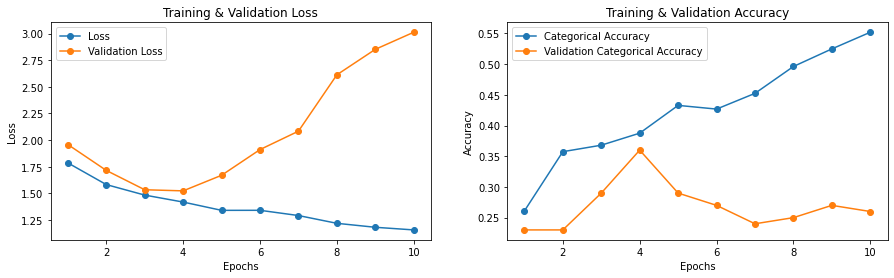

In [45]:
plot_history(hist1)

## 2. Increase model depth

In [46]:
hist2, model2 = train_conv_3D_model(name='model_2_CNN_3D',
                                    batch_size = 128,            # set batch size for training and validation
                                    num_epochs = 20,             # Define the number of epochs for training
                                    frame_rate = 10,             # set frame rate
                                    frame_size = (80, 80),       # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),       # set convolution filter size
                                    full_connected = [64, 32]    # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_CNN_Conv_3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 80, 80, 3)]   0         
                                                                 
 rescale (Rescaling)         (None, 10, 80, 80, 3)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 10, 80, 80, 32)    2624      
                                                                 
 batch_normalization_4 (Batc  (None, 10, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 10, 80, 80, 32)    0         
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 5, 40, 40, 32)    0         
 3D)                                 

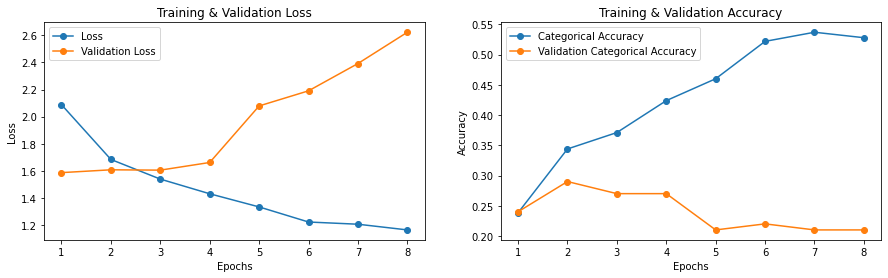

In [47]:
plot_history(hist2)

## 3. Increase FPS to 15



In [ ]:
hist3, model3 = train_conv_3D_model(name='model_3_CNN_3D',
                                    batch_size = 128,               # set batch size for training and validation
                                    num_epochs = 20,                # Define the number of epochs for training
                                    frame_rate = 15,                # set frame rate
                                    frame_size = (80, 80),          # set frame size
                                    conv_blocks = [32, 64, 128],    # List of convolution block filters
                                    conv_filter = (3,3,3),          # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_CNN_Conv_3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 80, 80, 3)]   0         
                                                                 
 rescale (Rescaling)         (None, 15, 80, 80, 3)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 80, 80, 32)    2624      
                                                                 
 batch_normalization_9 (Batc  (None, 15, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 15, 80, 80, 32)    0         
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 7, 40, 40, 32)    0         
 3D)                                 

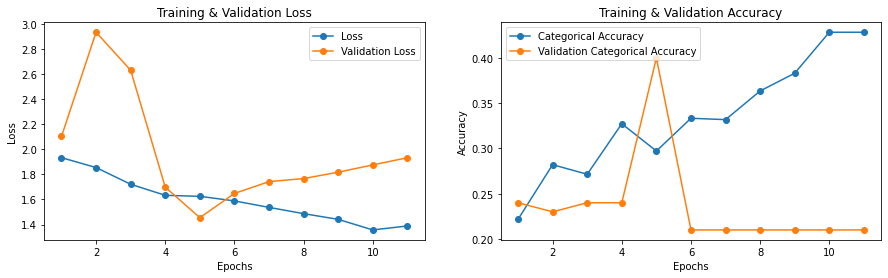

In [ ]:
plot_history(hist3)

## 4. Increase FPS to 30

batch size reduced due to ut of memory

In [56]:
hist4, model4 = train_conv_3D_model(name='model_4_CNN_3D',
                                    batch_size = 64,                # set batch size for training and validation
                                    num_epochs = 20,                # Define the number of epochs for training
                                    frame_rate = 15,                # set frame rate
                                    frame_size = (80, 80),          # set frame size
                                    conv_blocks = [32, 64, 128],    # List of convolution block filters
                                    conv_filter = (3,3,3),          # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_CNN_Conv_3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 15, 80, 80, 3)]   0         
                                                                 
 rescale (Rescaling)         (None, 15, 80, 80, 3)     0         
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 80, 80, 32)    2624      
                                                                 
 batch_normalization_33 (Bat  (None, 15, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 15, 80, 80, 32)    0         
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 7, 40, 40, 32)    0         
 g3D)                                

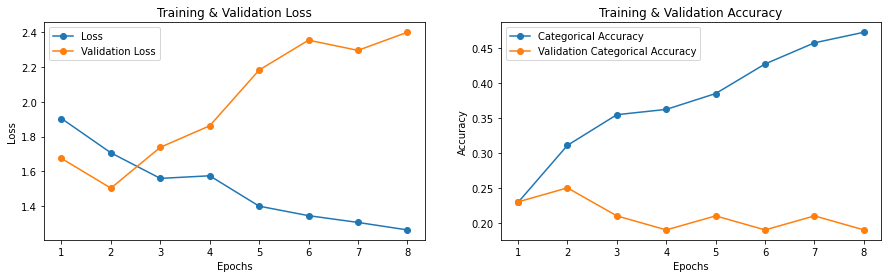

In [57]:
plot_history(hist4)

## 5. increase input frame size to 112x112

reduce batch size, memory issues

In [58]:
hist5, model5 = train_conv_3D_model(name='model_5_CNN_3D',
                                    batch_size = 32,                # set batch size for training and validation
                                    num_epochs = 20,                # Define the number of epochs for training
                                    frame_rate = 30,                # set frame rate
                                    frame_size = (112, 112),        # set frame size
                                    conv_blocks = [32, 64, 128],    # List of convolution block filters
                                    conv_filter = (3,3,3),          # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_CNN_Conv_3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 30, 112, 112, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 30, 112, 112, 3)   0         
                                                                 
 conv3d_20 (Conv3D)          (None, 30, 112, 112, 32)  2624      
                                                                 
 batch_normalization_39 (Bat  (None, 30, 112, 112, 32)  128      
 chNormalization)                                                
                                                                 
 activation_39 (Activation)  (None, 30, 112, 112, 32)  0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 

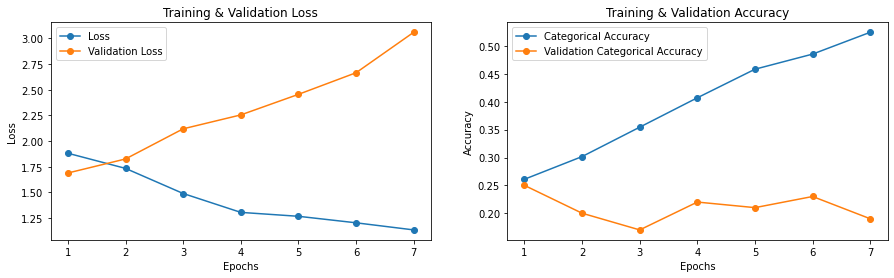

In [59]:
plot_history(hist5)

## 6. increase input frame size to 160x160

mem issues, reduce batch

In [94]:
hist6, model6 = train_conv_3D_model(name='model_6_CNN_3D',
                                    batch_size = 12,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 30,           # set frame rate
                                    frame_size = (160, 160),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_CNN_Conv_3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 30, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 30, 160, 160, 3)   0         
                                                                 
 conv3d_48 (Conv3D)          (None, 30, 160, 160, 32)  2624      
                                                                 
 batch_normalization_116 (Ba  (None, 30, 160, 160, 32)  128      
 tchNormalization)                                               
                                                                 
 activation_101 (Activation)  (None, 30, 160, 160, 32)  0        
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 

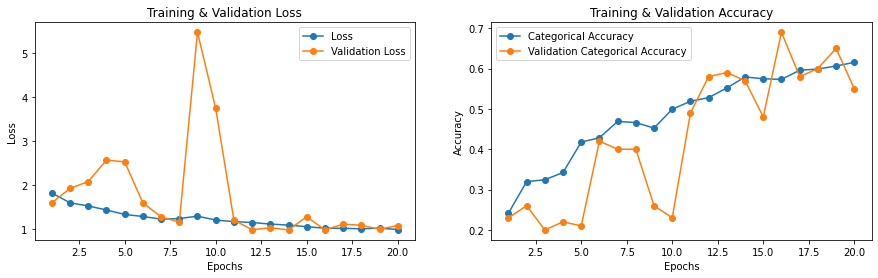

In [95]:
plot_history(hist6)

## 7. keep frame 160x160 but reduce frame rate to 15

In [62]:
hist7, model7 = train_conv_3D_model(name='model_7_CNN_3D',
                                    batch_size = 32,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 15,           # set frame rate
                                    frame_size = (160, 160),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [12, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_CNN_Conv_3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 15, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 15, 160, 160, 3)   0         
                                                                 
 conv3d_26 (Conv3D)          (None, 15, 160, 160, 32)  2624      
                                                                 
 batch_normalization_51 (Bat  (None, 15, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 activation_51 (Activation)  (None, 15, 160, 160, 32)  0         
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 

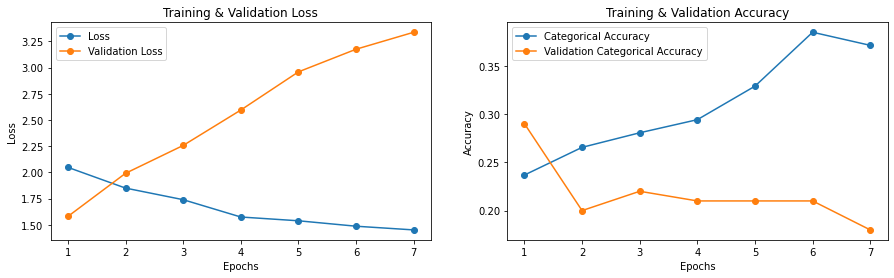

In [63]:
plot_history(hist7)

## 8. keep frame 160x160 but reduce frame rate to 10

In [65]:
hist8, model8 = train_conv_3D_model(name='model_8_CNN_3D',
                                    batch_size = 32,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 10,           # set frame rate
                                    frame_size = (160, 160),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_CNN_Conv_3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 10, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 10, 160, 160, 3)   0         
                                                                 
 conv3d_32 (Conv3D)          (None, 10, 160, 160, 32)  2624      
                                                                 
 batch_normalization_63 (Bat  (None, 10, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 activation_63 (Activation)  (None, 10, 160, 160, 32)  0         
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 

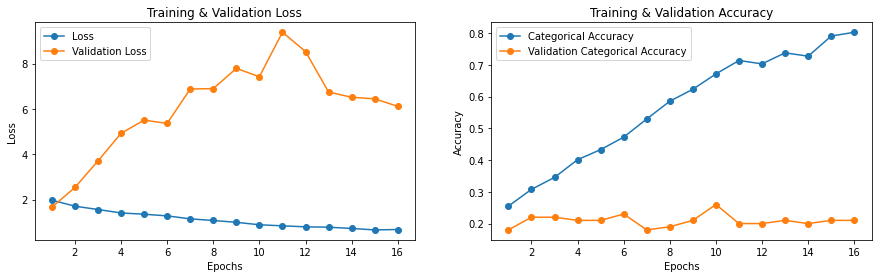

In [66]:
plot_history(hist8)

## 9. Train very very large model

In [67]:
hist9, model9 = train_conv_3D_model(name='model_9_CNN_3D',
                                    batch_size = 16,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 30,           # set frame rate
                                    frame_size = (160, 160),     # set frame size
                                    conv_blocks = [32, 64, 128, 256], # List of convolution block filters
                                    conv_filter = (5,5,5),     # set convolution filter size
                                    full_connected = [256, 128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_CNN_Conv_3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 30, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 30, 160, 160, 3)   0         
                                                                 
 conv3d_35 (Conv3D)          (None, 30, 160, 160, 32)  12032     
                                                                 
 batch_normalization_69 (Bat  (None, 30, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 activation_69 (Activation)  (None, 30, 160, 160, 32)  0         
                                                                 
 max_pooling3d_35 (MaxPoolin  (None, 

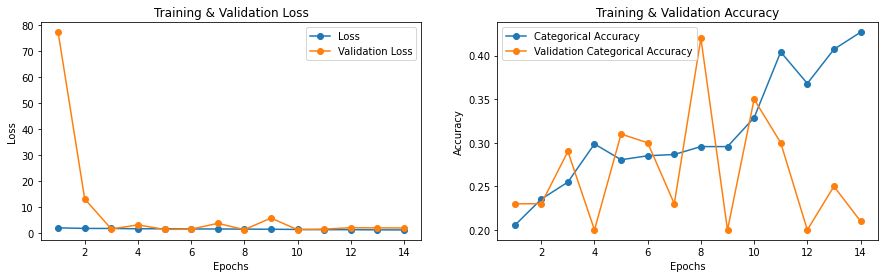

In [68]:
plot_history(hist9)

## 10. retraining 6 for 50 epochs

Model 6 seems to be performing moderately well. hence raunning the training again with 50 epochs.

In [69]:
hist10, model10 = train_conv_3D_model(name='model_10_CNN_3D',
                                    batch_size = 16,           # set batch size for training and validation
                                    num_epochs = 50,           # Define the number of epochs for training
                                    frame_rate = 30,           # set frame rate
                                    frame_size = (160, 160),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3,3),     # set convolution filter size
                                    full_connected = [128, 64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_CNN_Conv_3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 30, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 30, 160, 160, 3)   0         
                                                                 
 conv3d_39 (Conv3D)          (None, 30, 160, 160, 32)  2624      
                                                                 
 batch_normalization_77 (Bat  (None, 30, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 activation_77 (Activation)  (None, 30, 160, 160, 32)  0         
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 

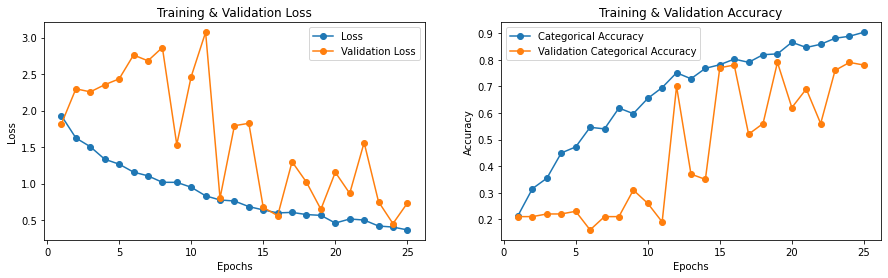

In [70]:
plot_history(hist10)

# CNN-2D + GRU


**Building a CNN + GRU Model for Video Gesture Recognition**  

**Overview**  

A CNN + RNN hybrid model combines the strengths of Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs) to process spatiotemporal data like videos.  

- CNN extracts spatial features from individual video frames.  
- RNN (LSTM/GRU) captures temporal dependencies across frames, understanding the motion dynamics of gestures over time.  

**How CNN + RNN Works for Gesture Recognition**

1. Frame-wise Feature Extraction: A 2D CNN processes each frame, extracting important spatial features.  
2. Temporal Modeling with RNN:  
   - The extracted CNN features from multiple frames are passed sequentially to an RNN (LSTM/GRU).  
   - The RNN captures the sequence patterns, learning the motion trajectory of the gesture.  
3. Final Classification: The last hidden state of the RNN is passed to a fully connected layer, followed by a softmax classifier to predict the gesture class.  

**Pros of CNN + RNN for Gesture Recognition**

 Efficient feature extraction – CNN focuses on spatial details, while RNN captures motion flow over time.  
 Lower computational cost – Uses 2D CNNs instead of 3D CNNs, reducing GPU memory usage.  
 Effective temporal modeling – RNNs (LSTMs/GRUs) are designed for sequential data, making them ideal for gesture recognition.  

**Cons of CNN + RNN**

 Slower inference – Sequential nature of RNNs makes them slower than 3D CNNs, as they process frames one by one.  
 Difficulty handling long sequences – Standard RNNs struggle with long video sequences, though GRUs/LSTMs mitigate this issue.  
 Less effective for fine-grained motion – RNNs may not capture fast, small-scale movements as well as 3D CNNs.  

The CNN extracts frame-wise features, while the RNN models the motion sequence, making it well-suited for recognizing hand gestures over time.  

We will implement a CNN + GRU model, optimizing it for gesture recognition by choosing the right frame rate, input resolution, and training strategies. 

**Note: LSTM vs GRU** 

We will be using GRU instead of LSTM since LSTM consists of three gates that control the flow of information, whereas GRU simplifies LSTM by using only two gates.
Hence GRU has fewer parameters and smaller model size, and we are preferring it since in put problem statement speed, efficiency and model size are important.

### Define cnn_rnn_model function

In [71]:
def cnn_rnn_model(frame_rate, frame_size, conv_blocks, conv_filter, gru_layers, full_connected):


    inputs = Input(shape=(frame_rate, frame_size[0], frame_size[1], 3))

    # Rescale pixel values to range [0,1] by dividing by 255
    x = Rescaling(scale=1./255, name="rescale")(inputs)

    # Create Convolution Blocks
    for filters in conv_blocks:
        x = TimeDistributed(Conv2D(filters, conv_filter, padding='same', activation='relu'))(x)
        x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(MaxPooling2D())(x)
        x = Dropout(0.2)(x)

    # Flatten the feature map into a 1D vector
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    # GRU Layers - Ensure only the last GRU layer has return_sequences=False
    for i, cells in enumerate(gru_layers):
        return_seq = i < len(gru_layers) - 1  # True for all but the last GRU layer
        x = GRU(cells, return_sequences=return_seq)(x)
        x = Dropout(0.2)(x)

    # Fully Connected Layer:
    for units in full_connected:
        x = Dense(units)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)

    # Output Layer:
    x = Dense(5, activation="softmax")(x)

    # Define the Model
    model = tf.keras.Model(inputs, x, name="Gesture_Detection_cnn_rnn")

    return model  # Return the created model

### Define train_cnn_rnn_model function

In [72]:
def train_cnn_rnn_model(name, batch_size, num_epochs, frame_rate, frame_size, conv_blocks, conv_filter, gru_layers, full_connected):

    # Generate data
    train_generator  = generator(train_data_path, train_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    val_generator = generator(val_data_path, val_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    # Create the model instance
    model = cnn_rnn_model(frame_rate=frame_rate, frame_size=frame_size, conv_blocks=conv_blocks, conv_filter=conv_filter, gru_layers=gru_layers, full_connected=full_connected)

    # Define optimizer
    optimiser = Adam(learning_rate=0.001)

    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()

    # ModelCheckpoint saves the model during training based on performance.
    checkpoint = ModelCheckpoint("content/Gesture_Det_"+name+".keras", monitor="val_categorical_accuracy", save_best_only=True, mode="max", verbose=1)

    # EarlyStopping stops training when a monitored metric stops improving.
    earlystop = EarlyStopping( monitor="val_categorical_accuracy", patience=6, mode="max", restore_best_weights=True, verbose=1)

    # ReduceLROnPlateau is a callback that reduces the learning rate when a metric has stopped improving.
    learn_control = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=4, verbose=1, factor=0.2, min_lr=1e-7)


    num_train_sequences = len(train_folders_data)   # Calculate the number of training sequences from the training dataset
    num_val_sequences = len(val_folders_data)       # Calculate the number of validation sequences from the validation dataset
    train_batches_per_epoch = (num_train_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for training
    val_batches_per_epoch = (num_val_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for validation

    # Fit model
    hist = model.fit(train_generator,
          epochs=num_epochs, steps_per_epoch=train_batches_per_epoch,
          validation_data=val_generator, validation_steps=val_batches_per_epoch,
          callbacks=[ checkpoint, earlystop, learn_control],
          verbose=1
          )

    return hist, model


## 11. create small cnn-rnn model

In [73]:
hist11, model11 = train_cnn_rnn_model(name='model_11_CNN_RNN_GRU',
                                    batch_size = 16,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 15,           # set frame rate
                                    frame_size = (80, 80),     # set frame size
                                    conv_blocks = [32, 64, 128], # List of convolution block filters
                                    conv_filter = (3,3),     # set convolution filter size
                                    gru_layers = [128],
                                    full_connected = [64, 32]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_cnn_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 15, 80, 80, 3)]   0         
                                                                 
 rescale (Rescaling)         (None, 15, 80, 80, 3)     0         
                                                                 
 time_distributed (TimeDistr  (None, 15, 80, 80, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 80, 80, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 40, 40, 32)   0         
 tributed)                                                       
                                         

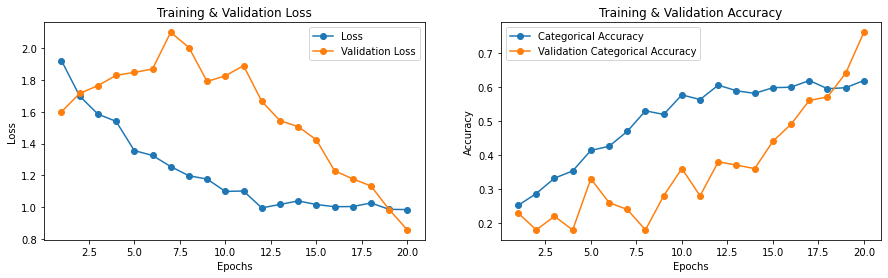

In [74]:
plot_history(hist11)

## 12. use deeper model

In [75]:
hist12, model12 = train_cnn_rnn_model(name='model_12_CNN_RNN_GRU',
                                    batch_size = 16,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 30,           # set frame rate
                                    frame_size = (120, 120),     # set frame size
                                    conv_blocks = [32, 64, 128, 256], # List of convolution block filters
                                    conv_filter = (3,3),     # set convolution filter size
                                    gru_layers = [256],
                                    full_connected = [128, 64]  # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_cnn_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 30, 120, 120, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 30, 120, 120, 3)   0         
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 120, 120, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 60, 60, 32)   0         
 stributed)                              

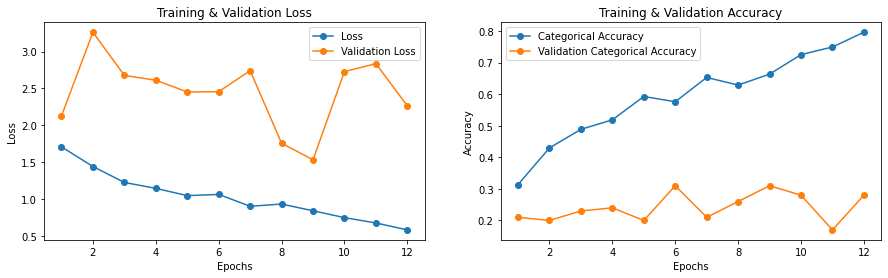

In [76]:
plot_history(hist12)

## 13. use better image size

In [77]:
hist13, model13 = train_cnn_rnn_model(name='model_13_CNN_RNN_GRU',
                                    batch_size = 16,           # set batch size for training and validation
                                    num_epochs = 20,           # Define the number of epochs for training
                                    frame_rate = 30,           # set frame rate
                                    frame_size = (160, 160),   # set frame size
                                    conv_blocks = [32, 64, 128, 256], # List of convolution block filters
                                    conv_filter = (3,3),       # set convolution filter size
                                    gru_layers = [256],
                                    full_connected = [128, 64] # set number of neurons in fully connected layers
                                    )

Model: "Gesture_Detection_cnn_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 30, 160, 160, 3)  0         
                             ]                                   
                                                                 
 rescale (Rescaling)         (None, 30, 160, 160, 3)   0         
                                                                 
 time_distributed_23 (TimeDi  (None, 30, 160, 160, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 30, 160, 160, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 30, 80, 80, 32)   0         
 stributed)                              

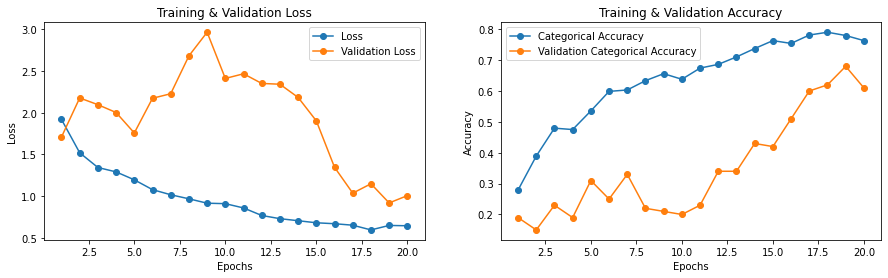

In [78]:
plot_history(hist13)

# MobileNet + GRU (non-trainable base)

**Building a CNN + RNN Model with Transfer Learning for Video Gesture Recognition**

**Overview**

To improve efficiency and performance, we will leverage transfer learning in our CNN + RNN model for video gesture recognition. Instead of training a CNN from scratch, we will use a pre-trained CNN (like MobileNet, ResNet, or InceptionV3) to extract spatial features from video frames. These features will then be passed to an RNN (LSTM/GRU) to learn temporal dependencies and classify gestures.  

**How It Works**

1. Frame-wise Feature Extraction with a Pre-trained CNN
   - Each video frame is processed through a pre-trained CNN (e.g., MobileNet, ResNet).  
   - The CNN is frozen (or fine-tuned on our dataset) to extract high-level spatial features.  
   - Instead of raw pixel data, the extracted feature vectors are used as inputs to the RNN.  

2. Temporal Modeling with RNN (LSTM/GRU)  
   - The extracted features from multiple frames are fed sequentially into an LSTM/GRU network.  
   - The RNN captures motion dynamics and temporal dependencies between frames.  

3. Classification Layer  
    - The final RNN hidden state is passed to a fully connected layer with a softmax activation to predict the gesture class.  

**Pros of Using Transfer Learning in CNN + RNN**
- Reduces training time – Instead of learning features from scratch, we use a pre-trained CNN, making training much faster.  
- Improves accuracy with limited data – Pre-trained models are trained on large datasets (e.g., ImageNet), enabling better feature extraction even with a small dataset.  
- Efficient computation – CNN processes each frame only once, and only the RNN needs to handle sequential dependencies.  

**Cons of CNN + RNN with Transfer Learning**

- Higher memory usage – Using a pre-trained CNN can increase model size, requiring more RAM and VRAM.  
- Less fine-grained feature learning – Transfer learning may not perfectly align with gesture-specific features, requiring fine-tuning.  
- Not ideal for very fast gestures – RNNs process frames sequentially, which can be slower than 3D CNNs for fast, complex motions.  


**We will implement a CNN + LSTM/GRU model with transfer learning, optimize it for gesture recognition, and experiment with different pre-trained CNNs to find the best balance between accuracy and efficiency.** 


## Define train_cnn_rnn_model_with_TL function

In [17]:
def train_cnn_rnn_model_with_TL(name, batch_size, num_epochs, frame_rate, frame_size, model, learning_rate):

    # Generate data
    train_generator  = generator(train_data_path, train_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    val_generator = generator(val_data_path, val_folders_data, batch_size=batch_size, frame_rate=frame_rate, frame_size=frame_size, verbose=-1)

    # Define optimizer
    optimiser = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.summary()

    # ModelCheckpoint saves the model during training based on performance.
    checkpoint = ModelCheckpoint("content/Gesture_Det_"+name+".keras", monitor="val_categorical_accuracy", save_best_only=True, mode="max", verbose=1)

    # EarlyStopping stops training when a monitored metric stops improving.
    earlystop = EarlyStopping( monitor="val_categorical_accuracy", patience=12, mode="max", restore_best_weights=True, verbose=1)

    # ReduceLROnPlateau is a callback that reduces the learning rate when a metric has stopped improving.
    learn_control = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=5, verbose=1, factor=0.2, min_lr=1e-8)


    num_train_sequences = len(train_folders_data)   # Calculate the number of training sequences from the training dataset
    num_val_sequences = len(val_folders_data)       # Calculate the number of validation sequences from the validation dataset
    train_batches_per_epoch = (num_train_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for training
    val_batches_per_epoch = (num_val_sequences + batch_size - 1) // batch_size
                                                    # Calculate the number of batches per epoch for validation

    # Fit model
    hist = model.fit(train_generator,
          epochs=num_epochs, steps_per_epoch=train_batches_per_epoch,
          validation_data=val_generator, validation_steps=val_batches_per_epoch,
          callbacks=[ checkpoint, earlystop, learn_control],
          verbose=1
          )

    return hist, model


## Mobilenet

We will first use MobileNet, a lightweight convolutional neural network pre-trained on ImageNet, for transfer learning in our video gesture recognition model. MobileNet is designed for efficient feature extraction while maintaining high accuracy, making it ideal for our use case.  

**Why MobileNet?**

- Lightweight and Fast – MobileNet is optimized for speed and efficiency, making it suitable for real-time applications and low-resource environments.  
- Pre-trained on ImageNet – It has learned rich spatial features from millions of images, enabling effective feature extraction from gesture frames.  
- Reduces Training Time – Instead of training a CNN from scratch, we leverage MobileNet’s pre-learned filters, allowing us to train faster with fewer data.  
- Works Well with RNNs – Extracted features from MobileNet can be fed into an RNN (LSTM/GRU) for temporal modeling, ensuring efficient gesture recognition.  

**Why ImageNet Pre-training Helps?**

MobileNet trained on ImageNet has already learned to recognize edges, textures, and object structures, which are also useful for distinguishing hand shapes and movements in gestures. Instead of learning these low-level patterns from scratch, our model focuses only on fine-tuning for gesture-specific recognition.  

By using MobileNet trained on ImageNet, we achieve a balance between accuracy, efficiency, and speed, making it an excellent choice for gesture recognition with transfer learning.  


In [18]:
from keras.applications import mobilenet

### Define create_cnn_rnn_tf_model function

In [19]:
def create_cnn_rnn_tf_model(gru_cells, dense_neurons, dropout, train_base_model=False):

    model = Sequential()

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,120,3)))

    for layer in model.layers:
            layer.trainable = train_base_model

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))

    return model

## 14. model 14

**Reduce Learning Rate for Transfer Learning**  
When using a pre-trained model (e.g., MobileNet, EfficientNetB0) for transfer learning, we typically freeze its base layers and train only the newly added layers.
In this phase, a moderate learning rate (e.g., 0.0001 or 0.00001) is used to train the top layers without disturbing the pre-trained weights.  

In [20]:
hist14, model14 = train_cnn_rnn_model_with_TL(name='model_14_MobileNet_RNN_GRU',
                                              batch_size = 16,           # set batch size for training and validation
                                              num_epochs = 20,           # Define the number of epochs for training
                                              frame_rate = 30,           # set frame rate
                                              frame_size = (120, 120),   # set frame size
                                              model=create_cnn_rnn_tf_model(gru_cells=128, dense_neurons=128, dropout=0.25, train_base_model=False),
                                              learning_rate=0.0001
                                              )

2025-03-03 02:17:09.425995: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-03-03 02:17:09.426054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


17235968/17225924 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                         

2025-03-03 02:17:18.783555: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 1.8371 - categorical_accuracy: 0.2127
Epoch 00001: val_categorical_accuracy improved from -inf to 0.26000, saving model to content/Gesture_Det_model_14_MobileNet_RNN_GRU.keras
42/42 [==============================] - 46s 985ms/step - loss: 1.8371 - categorical_accuracy: 0.2127 - val_loss: 1.6340 - val_categorical_accuracy: 0.2600 - lr: 1.0000e-04
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.6270 - categorical_accuracy: 0.2821
Epoch 00002: val_categorical_accuracy improved from 0.26000 to 0.35000, saving model to content/Gesture_Det_model_14_MobileNet_RNN_GRU.keras
42/42 [==============================] - 40s 973ms/step - loss: 1.6270 - categorical_accuracy: 0.2821 - val_loss: 1.5664 - val_categorical_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 1.4827 - categorical_accuracy: 0.3786
Epoch 00003: val_categorical_accuracy improved from 0.35000 to 0.390

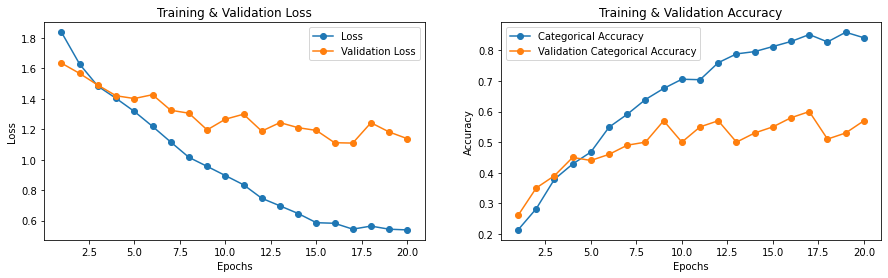

In [ ]:
plot_history(hist14)

## 15. model 15

model is overfitting, increasing dropout

In [ ]:
hist15, model15 = train_cnn_rnn_model_with_TL(name='model_15_MobileNet_RNN_GRU',
                                              batch_size = 16,           # set batch size for training and validation
                                              num_epochs = 20,           # Define the number of epochs for training
                                              frame_rate = 30,           # set frame rate
                                              frame_size = (120, 120),   # set frame size
                                              model=create_cnn_rnn_tf_model(gru_cells=128, dense_neurons=128, dropout=0.5, train_base_model=False),
                                              learning_rate=0.0001
                                              )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)              

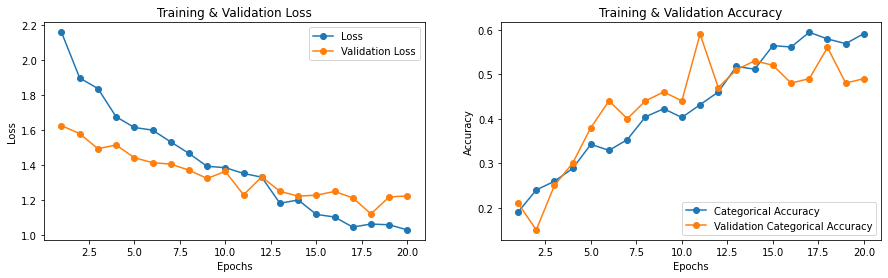

In [ ]:
plot_history(hist15)

## MobileNet + GRU (trainable base) 


**Enabling Training for the Base Model**

Initially, when using a pre-trained CNN (e.g., MobileNet, EfficientNetB0) for transfer learning, we freeze its layers to retain general features learned from ImageNet. However, to further adapt the model to gesture recognition, we need to unfreeze and fine-tune the base model’s layers.  

By turning on training for the base model, we refine the feature extractor to better recognize gestures, achieving higher accuracy and adaptability while leveraging the benefits of transfer learning.  

### 16. Model 16

turning on training for base model

In [ ]:
hist16, model16 = train_cnn_rnn_model_with_TL(name='model_16_MobileNet_Train_RNN_GRU',
                                              batch_size = 16,           # set batch size for training and validation
                                              num_epochs = 50,           # Define the number of epochs for training
                                              frame_rate = 30,           # set frame rate
                                              frame_size = (120, 120),   # set frame size
                                              model=create_cnn_rnn_tf_model(gru_cells=128, dense_neurons=128, dropout=0.25, train_base_model=True),
                                              learning_rate=0.0001
                                              )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 30, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 128)              

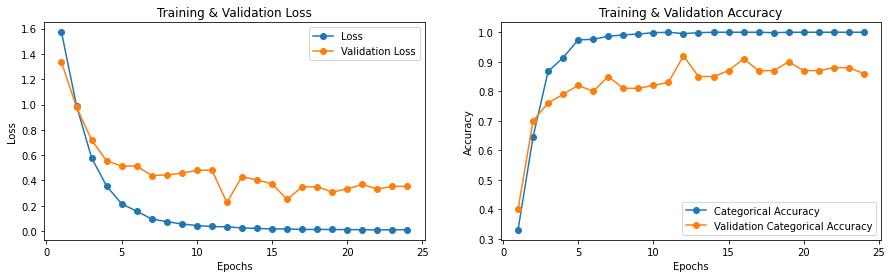

In [ ]:
plot_history(hist16)

updating model to handle 160*160 size images

In [32]:
def create_cnn_rnn_tf_model(gru_cells, dense_neurons, dropout, train_base_model=False):

    model = Sequential()

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(30,160,160,3)))

    for layer in model.layers:
            layer.trainable = train_base_model

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))

    return model

### 17. increased dropout and increased image to 160x160

In [33]:
hist17, model17 = train_cnn_rnn_model_with_TL(name='model_17_MobileNet_Train_RNN_GRU',
                                              batch_size = 16,           # set batch size for training and validation
                                              num_epochs = 50,           # Define the number of epochs for training
                                              frame_rate = 30,           # set frame rate
                                              frame_size = (160, 160),   # set frame size
                                              model=create_cnn_rnn_tf_model(gru_cells=128, dense_neurons=128, dropout=0.5, train_base_model=True),
                                              learning_rate=0.0001
                                              )

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 30, 5, 5, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 30, 5, 5, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 30, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 30, 4096)         0         
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 128)              

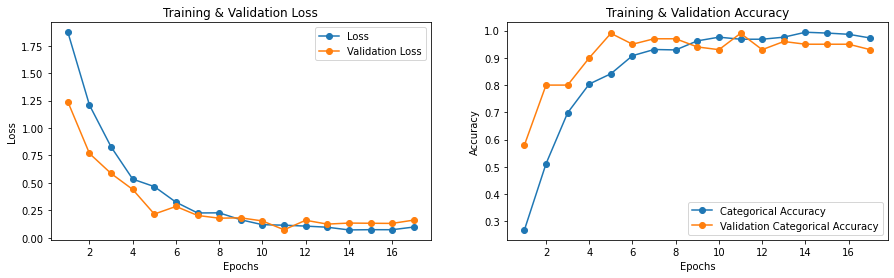

In [ ]:
plot_history(hist17)

## EfficientNetB0 + GRU (trainable base)

After experimenting with MobileNet, we are now using EfficientNetB0, a more advanced CNN architecture pre-trained on ImageNet, for transfer learning in our video gesture recognition model. EfficientNetB0 offers a better balance between accuracy and efficiency, making it a strong candidate for improving performance.  

**Why EfficientNetB0**

- Higher Accuracy than MobileNet – EfficientNetB0 uses compound scaling, which improves accuracy while maintaining efficiency.  
- Better Feature Extraction – It captures more detailed spatial features compared to MobileNet, leading to improved gesture recognition.  
- Optimized for Efficiency – Despite being more powerful, EfficientNetB0 is computationally efficient, making it a great alternative without significantly increasing training time.  
- Scalability – If needed, we can switch to larger EfficientNet variants (B1, B2, etc.) for further accuracy improvements.  

**Why Move from MobileNet to EfficientNetB0?**

- MobileNet is lightweight but may not extract fine-grained details as effectively.  
- EfficientNetB0 offers better accuracy while still being efficient enough for real-time applications.  
- Pre-trained on ImageNet, it provides a solid feature extractor without requiring extensive training.  


Using EfficientNetB0 after MobileNet allows us to experiment with a more powerful CNN while keeping our model lightweight and efficient for gesture recognition with transfer learning.  


In [38]:
from tensorflow.keras.applications import EfficientNetB0

### Define create_cnn_rnn_et_model function

In [39]:
def create_cnn_rnn_et_model(gru_cells, dense_neurons, dropout, train_base_model=False):

    model = Sequential()

    efficientnet_transfer = EfficientNetB0(weights='imagenet', include_top=False)
    model.add(TimeDistributed(efficientnet_transfer,input_shape=(30,160,160,3)))

    for layer in model.layers:
            layer.trainable = train_base_model

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))

    return model

## 18. Model 18

In [42]:
hist18, model18 = train_cnn_rnn_model_with_TL(name='model_18_EfficientNetB0_Train_RNN_GRU',
                                              batch_size = 8,           # set batch size for training and validation
                                              num_epochs = 50,           # Define the number of epochs for training
                                              frame_rate = 30,           # set frame rate
                                              frame_size = (160, 160),   # set frame size
                                              model=create_cnn_rnn_et_model(gru_cells=128, dense_neurons=128, dropout=0.5, train_base_model=True),
                                              learning_rate=0.0001
                                              )

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_40 (TimeDi  (None, 30, 5, 5, 1280)   4049571   
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 30, 5, 5, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 30, 2, 2, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 30, 5120)         0         
 stributed)                                                      
                                                                 
 gru_10 (GRU)                (None, 128)             

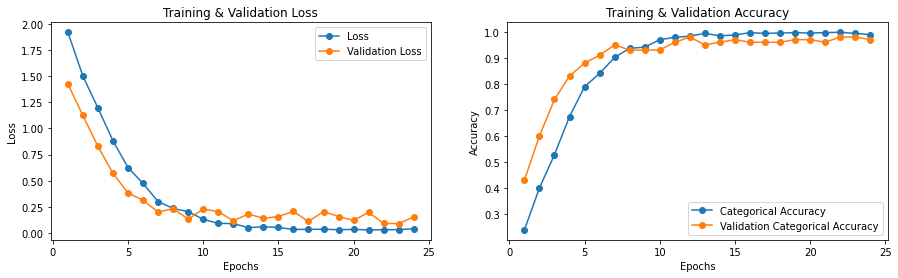

In [ ]:
plot_history(hist18)